In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [3]:
!pip install factor_analyzer  
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


In [6]:
def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

# Preprocessing

In [7]:
beh_cols = get_behaviour_cols()
df_fa_input = get_preprocessed_data(impute=True, impute_cols=beh_cols)

In [8]:
beh_cols

['Q1_1_feel_exposed',
 'Q1_2_covid_is_threat',
 'Q2_1_easy_to_follow_advice',
 'Q2_2_can_follow_advice_if_wanted',
 'Q2_3_if_follow_advice_safe',
 'Q2_4_if_follow_advice_others_safe',
 'Q2_5_follow_advice_relationships_impared',
 'Q2_6_follow_advice_life_degraded',
 'Q3_1_aware_hand_hygiene',
 'Q3_2_avoid_contact',
 'Q3_3_ensure_frequent_cleaning',
 'Q3_4_avoid_risk_groups',
 'Q3_5_keep_distance',
 'Q3_6_avoid_crowds',
 'Q3_7_minimize_activities_w_contact',
 'Q3b_1_sneeze_sleeve',
 'Q4_1_nr_contact_nonhouse_family',
 'Q4_2_nr_contact_colleagues',
 'Q4_3_nr_contact_friends',
 'Q4_4_nr_contact_strangers',
 'Q5_1_others_took_distance',
 'Q5_2_others_follow_advice',
 'Q5_3_others_not_care_spreading',
 'Q5_4_yourself_kept_distance',
 'Q5_5_feel_urge_scold',
 'Q6_1_sanctions_are_too_harsh',
 'Q6_2_advices_important',
 'Q6_3_others_can_avoid_spreading',
 'Q6_4_advices_create_fair_burden_dristribution',
 'Q6_5_ownership_of_advice',
 'Q6_6_clear_information_on_advice_reason',
 'Q6_7_advice_limi

In [9]:
scaler = MinMaxScaler()
fa_input = scaler.fit_transform(df_fa_input[beh_cols].to_numpy())
fa_input.shape

(118151, 34)

# Voraussetzungen prüfen
ref: Klaus Backhaus et al. Multivariate analysemethoden. Springer, 2021, pp. 413–488

First, Bartlett’s test (test for sphericity) tests the null hypothesis that the sample originates from
a population in which the variables are uncorrelated. Accordingly, the alternative hypothesis shows
that the variables are correlated. This must be shown for a factor analysis to be appropriate.

In [10]:
# P Value should be smaller 0.05
statistic, p_value = calculate_bartlett_sphericity(fa_input)
print(statistic, p_value)

1259639.5747444362 0.0


In [11]:
p_value

0.0

Second, the Kaiser-Meyer-Olkin (KMO) criterion, considers the bivariate partial correlations between all variables. This correlation describes the degree of dependence between two variables after excluding the influences of all other variables. The ideal value for a factor analysis is close to 1. In practice, values greater than 0.5 are considered sufficient; values greater than 0.8 are recommended.

In [12]:
#KMO should be greater or equal to 0.5
kmo_per_item, kmo_total = calculate_kmo(fa_input)
kmo_total

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.903972908710264

In contrast, the Measure of Sampling Adequacy (MSA) as a third method assesses the suitability of individual variables for a factor analysis. This can also be determined with the help of the KMO. If individual variables have MSA values below 0.5, they can be excluded from the factor analysis.

In [13]:
kmo_per_item

array([0.79645448, 0.92093543, 0.90303503, 0.86390932, 0.92208718,
       0.88929548, 0.69802959, 0.77610222, 0.91668884, 0.94208921,
       0.92838833, 0.95841818, 0.94413475, 0.93354927, 0.91611283,
       0.92697916, 0.7367382 , 0.84446836, 0.79446218, 0.82431085,
       0.80610216, 0.80044302, 0.70378153, 0.93956008, 0.7997478 ,
       0.82038116, 0.93601628, 0.86980714, 0.94580925, 0.94835758,
       0.94327798, 0.77180354, 0.93299808, 0.92759874])

In [14]:
(kmo_per_item < 0.5).sum()

0

The fourth and last criterion is the anti-image covariance matrix. The anti-image represents the proportion of the variance that is independent of the other variables. Since factor analysis assumes that common factors are the basis of the variables, the variables are only suitable if they have a high common variance. Accordingly, the anti-image of the variables should be close to zero. As a rule of thumb, the data is suitable if less than 25\% of the non-diagonal elements of the matrix are different from zero.

In [15]:
# calc anti-image covariance matrix
R = np.corrcoef(fa_input, rowvar=False)
R_inv = np.linalg.inv(R)
temp = np.diagflat(R_inv.diagonal())
D = np.linalg.inv(temp)

In [16]:
anti_image_covariance_matrix = np.dot(np.dot(D, R_inv), D)

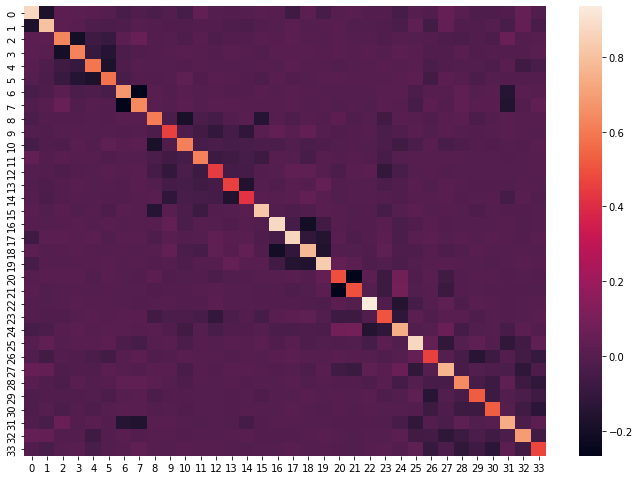

In [17]:
sns.heatmap(anti_image_covariance_matrix)

In [18]:
diff_zero_value = 0.05
num_non_diag_values_differ_from_zero = (anti_image_covariance_matrix > diff_zero_value).sum() + (anti_image_covariance_matrix < -diff_zero_value).sum() - anti_image_covariance_matrix.shape[0]
num_non_diag_values = anti_image_covariance_matrix.shape[0]**2 - - anti_image_covariance_matrix.shape[0]
percentage = num_non_diag_values_differ_from_zero / num_non_diag_values * 100
percentage

10.420168067226891

# Factor Analysis

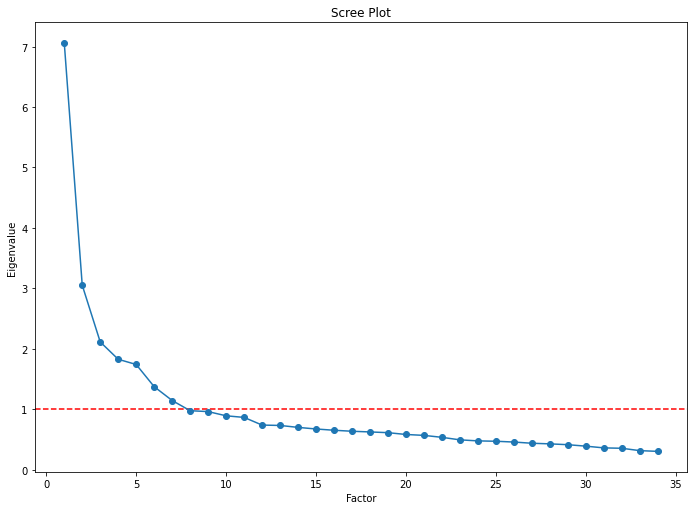

In [19]:
fa = FactorAnalyzer()
fa.fit(fa_input)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='dashed')
plt.plot(range(1,fa_input.shape[1]+1),ev, marker='o')
plt.savefig('images/scree_plot_factor_analysis.png')

In [20]:
ev

array([7.06465643, 3.05265365, 2.11458275, 1.82772628, 1.74141715,
       1.37434202, 1.14574202, 0.97703652, 0.96221848, 0.89260258,
       0.86621142, 0.73938988, 0.73302324, 0.70102415, 0.67459583,
       0.65361638, 0.63708973, 0.62577072, 0.6135795 , 0.58389764,
       0.56867304, 0.5366049 , 0.49472214, 0.47777588, 0.47169019,
       0.4585055 , 0.43867035, 0.42852118, 0.41473297, 0.39055991,
       0.36202195, 0.35553551, 0.3164069 , 0.30440321])

In [21]:
num_factors_one = (ev > 1).sum()
num_factors_avg = (ev > ev.mean()).sum()
print(f'Es gibt {num_factors_one} Eigenwerte, die größer als eins sind und {num_factors_avg} Eigenwerte, die größer als der Durchschnitt sind.')

Es gibt 7 Eigenwerte, die größer als eins sind und 7 Eigenwerte, die größer als der Durchschnitt sind.


In [22]:
fa = FactorAnalyzer(7, rotation='varimax')
fa.fit(fa_input)
loads = fa.loadings_

# Evaluate Factors

In [23]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

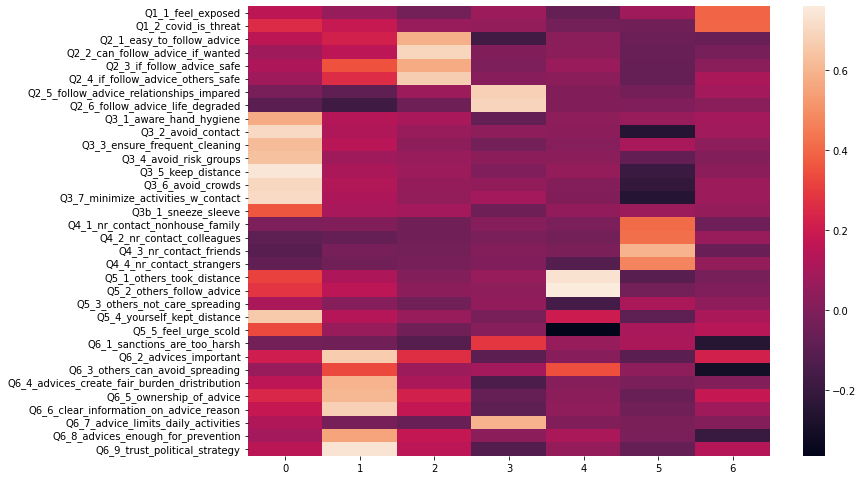

In [24]:
heatmap_data = pd.DataFrame(loads.T, columns=beh_cols).T
heatmap_loadings = sns.heatmap(heatmap_data)
fig = heatmap_loadings.get_figure()
fig.savefig("images/heatmap_factor_loadings.png")

In [25]:
heatmap_data

,0,1,2,3,4,5,6
Q1_1_feel_exposed,0.160343,0.059970,-0.034400,0.073684,-0.068358,0.077020,0.392825
Q1_2_covid_is_threat,0.257857,0.183816,0.064686,0.050235,-0.033571,-0.039915,0.397754
Q2_1_easy_to_follow_advice,0.157235,0.220984,0.586735,-0.168051,0.025237,-0.055849,-0.062376
Q2_2_can_follow_advice_if_wanted,0.073998,0.154329,0.696845,0.000614,0.033848,-0.065817,-0.024878
Q2_3_if_follow_advice_safe,0.114982,0.352303,0.572517,-0.005783,0.067242,-0.070889,0.025173
Q2_4_if_follow_advice_others_safe,0.079776,0.260225,0.668028,0.019954,0.026846,-0.069211,0.106631
Q2_5_follow_advice_relationships_impared,-0.022335,-0.085964,0.069432,0.676122,-0.000836,-0.030269,0.090489
Q2_6_follow_advice_life_degraded,-0.098873,-0.176736,-0.049854,0.691127,-0.000714,-0.001545,0.025030
Q3_1_aware_hand_hygiene,0.576871,0.132987,0.102996,-0.074199,0.035762,0.064281,0.092553
Q3_2_avoid_contact,0.704202,0.118588,0.063918,0.034769,0.034184,-0.253105,0.082585


In [26]:
dict_fa = {}
for i in np.arange(7):
  col_names = heatmap_data[heatmap_data[i] > 0.4][i].index.tolist()
  df_factor = df_fa_input[col_names]
  factor_alpha = cronbach_alpha(df_factor)
  temp_dict = {'Factor_Names': col_names, 'Data': df_factor, 'Cronbach_Alpha': factor_alpha}
  print(f'Factor {i} with Columns {col_names} has a Cronbachs Alpha of {factor_alpha}')
  dict_fa.update({i: temp_dict})

Factor 0 with Columns ['Q3_1_aware_hand_hygiene', 'Q3_2_avoid_contact', 'Q3_3_ensure_frequent_cleaning', 'Q3_4_avoid_risk_groups', 'Q3_5_keep_distance', 'Q3_6_avoid_crowds', 'Q3_7_minimize_activities_w_contact', 'Q5_4_yourself_kept_distance'] has a Cronbachs Alpha of 0.8805374855633787
Factor 1 with Columns ['Q6_2_advices_important', 'Q6_4_advices_create_fair_burden_dristribution', 'Q6_5_ownership_of_advice', 'Q6_6_clear_information_on_advice_reason', 'Q6_8_advices_enough_for_prevention', 'Q6_9_trust_political_strategy'] has a Cronbachs Alpha of 0.8474830148581048
Factor 2 with Columns ['Q2_1_easy_to_follow_advice', 'Q2_2_can_follow_advice_if_wanted', 'Q2_3_if_follow_advice_safe', 'Q2_4_if_follow_advice_others_safe'] has a Cronbachs Alpha of 0.7825797188291914
Factor 3 with Columns ['Q2_5_follow_advice_relationships_impared', 'Q2_6_follow_advice_life_degraded', 'Q6_7_advice_limits_daily_activities'] has a Cronbachs Alpha of 0.6950313690985894
Factor 4 with Columns ['Q5_1_others_took_di

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Create new factors

In [27]:
factor_names = ['F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_consequence_advice', 'F4_behaviour_others', 'F5_no_contacts', 'F6_perceived_threat']
new_variables = fa.transform(fa_input)
df_fa = pd.DataFrame(new_variables, columns=factor_names) # 
df_fa.head()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_consequence_advice,F4_behaviour_others,F5_no_contacts,F6_perceived_threat
0,0.790618,0.299629,0.599414,0.273981,-1.293292,-0.471874,0.153779
1,0.718930,0.189968,0.606866,-0.380493,0.291589,0.017772,0.477700
2,0.763634,0.272084,-1.850195,0.567088,-0.779487,1.437919,0.461035
3,0.317302,-2.581474,-2.928857,-1.346248,0.209341,-0.409844,-0.046174
4,1.109268,1.239288,-0.960084,0.554792,0.329865,-0.380758,-1.003847


In [29]:
df_fa.shape

(118151, 7)

In [30]:
df_fa.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118151 entries, 0 to 118150
Data columns (total 7 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   F0_cautious_behaviour                118151 non-null  float64
 1   F1_perception_advice                 118151 non-null  float64
 2   F2_applicability_usefullness_advice  118151 non-null  float64
 3   F3_consequence_advice                118151 non-null  float64
 4   F4_behaviour_others                  118151 non-null  float64
 5   F5_no_contacts                       118151 non-null  float64
 6   F6_perceived_threat                  118151 non-null  float64
dtypes: float64(7)
memory usage: 7.2 MB


#Combine with original data

In [52]:
subset_drop = factor_names + ['date']
df_fa_write = pd.concat([df_fa, df_fa_input], axis=1)
df_fa_write.dropna(subset=subset_drop, inplace=True)
df_fa_write.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111464 entries, 1 to 118150
Data columns (total 87 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   F0_cautious_behaviour                          111464 non-null  float64
 1   F1_perception_advice                           111464 non-null  float64
 2   F2_applicability_usefullness_advice            111464 non-null  float64
 3   F3_consequence_advice                          111464 non-null  float64
 4   F4_behaviour_others                            111464 non-null  float64
 5   F5_no_contacts                                 111464 non-null  float64
 6   F6_perceived_threat                            111464 non-null  float64
 7   gender                                         111464 non-null  float64
 8   postnr                                         111464 non-null  float64
 9   region                               

# Plot Factors

In [ ]:
#plt.scatter(x=df_fa[0], y=df_fa[1], alpha=0.01)
#plt.xlabel('Factor 1')
#plt.ylabel('Factor 2')
#plt.show()

In [53]:
start = '2021-02-01'
end = '2021-02-07'
df_plot = df_fa_write.copy()
df_plot.date = pd.to_datetime(df_plot.date)
in_range = (df_plot.date > start) & (df_plot.date < end)
df_plot = df_plot[in_range]
df_plot = df_plot[factor_names]

In [54]:
df_plot.shape

(1229, 7)

In [55]:
g = sns.PairGrid(data=df_plot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f4512f6edd0> (for post_execute):


KeyboardInterrupt: ignored

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_consequence_advice,F4_behaviour_others,F5_no_contacts,F6_perceived_threat
date,,,,,,,
2020-05-29,0.051476,0.084932,-0.155387,0.227231,-0.087443,0.186746,0.062240
2020-05-30,-0.053336,-0.022105,0.014819,-0.024810,0.054651,-0.063520,-0.018446
2020-05-31,0.117744,0.011575,-0.024197,-0.098082,0.079709,-0.022068,-0.032770
2020-06-01,-0.013528,-0.007835,-0.008323,0.025332,0.002632,-0.063274,-0.039544
2020-06-02,-0.012481,-0.025294,0.021843,0.172543,0.042531,-0.071550,-0.012557
...,...,...,...,...,...,...,...
2021-11-27,0.046757,-0.150122,0.011672,-0.123895,-0.026732,0.054119,-0.051892
2021-11-28,-0.101232,0.021117,0.082241,0.036648,0.201230,-0.044631,-0.020660
2021-11-29,-0.087991,0.003412,0.065305,0.036544,-0.125054,0.084655,-0.175218


In [70]:
import plotly.express as px
df_lineplot = df_fa_write[subset_drop].groupby('date').mean().reset_index()
df_lineplot[factor_names] = df_lineplot[factor_names].rolling(14).mean()
px.line(df_lineplot, x='date', y=factor_names)

# Write Data

In [ ]:
df_fa_write.to_csv('data/preprocessing/dim_reduction/220422_fa_data.csv', index=False)